In [43]:
using Pkg;
Pkg.add("Flux");
using Flux

  Resolving package versions...
No Changes to `C:\Users\mpoli\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\mpoli\.julia\environments\v1.5\Manifest.toml`


### Let's use MNIST data!

First of all we can use mnist training and test data in the following way.
The images are gray scale , 28x28 pixels, and each image has a label which indicate the number, we can visualize the i-th image and label by writing images[ i ] and labels[ i ]

In [44]:
images = Flux.Data.MNIST.images();
labels = Flux.Data.MNIST.labels()

images_test = Flux.Data.MNIST.images(:test)
labels_test = Flux.Data.MNIST.labels(:test)

print("label : " ,labels[1], "\nsize : ", size(images[1]))
images[1]

label : 5
size : (28, 28)



### Lets plot the distribution of our data
so the number of 0, 1 , 2 ...9  that we have in our training set and test set. I use the plot() function to combine the two histograms in a single plot

In [45]:
using Plots

p1 = histogram(labels, xticks=(0:1:9) , label = "train data") 
p2 = histogram(labels_test, xticks=(0:1:9), color = :green , label = "test data")

plot(p1, p2, layout = (2, 1), legend = true)


┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278


Your GR installation is incomplete. Rerun build step for GR package.


ERROR: LoadError: LoadError: InitError: Evaluation into the closed module `GR` breaks incremental compilation because the side effects will not be permanent. This is likely due to some other module mutating `GR` with `eval` during precompilation - don't do this.
Stacktrace:
 [1] eval at .\boot.jl:331 [inlined]
 [2] __init__() at C:\Users\mpoli\.julia\packages\GR\9Vi4m\src\GR.jl:280
 [3] _include_from_serialized(::String, ::Array{Any,1}) at .\loading.jl:697
 [4] _require_search_from_serialized(::Base.PkgId, ::String) at .\loading.jl:782
 [5] _require(::Base.PkgId) at .\loading.jl:1007
 [6] require(::Base.PkgId) at .\loading.jl:928
 [7] require(::Module, ::Symbol) at .\loading.jl:923
 [8] include(::Function, ::Module, ::String) at .\Base.jl:380
 [9] include at .\Base.jl:368 [inlined]
 [10] include(::String) at C:\Users\mpoli\.julia\packages\Plots\SjqWU\src\Plots.jl:1
 [11] top-level scope at C:\Users\mpoli\.julia\packages\Plots\SjqWU\src\Plots.jl:216
 [12] include(::Function, ::Module, :

LoadError: [91mFailed to precompile Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80] to C:\Users\mpoli\.julia\compiled\v1.5\Plots\ld3vC_k6BTT.ji.[39m

### We need to reshape our data

onehotbatch takes a batch of labels end convert it in [one hot vectors](https://en.wikipedia.org/wiki/One-hot), ex: the conversion of 3 is (0,0,1,0,0,0,0,0,0) becasue the third entry of the vector is 1. We need this conversion because it is easier to work with this representation.
Note that the **onecold** function is the inverse, from the one-hot we return to the original number




In [46]:
using Flux: onehotbatch, onecold

X = hcat(float.(reshape.(images, :))...) #stack all the images
Y = onehotbatch(labels, 0:9) # just a common way to encode categorical variables

10×60000 Flux.OneHotMatrix{Array{Flux.OneHotVector,1}}:
 0  1  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  1  0  0  1  0  1  0  0  0  0     0  0  0  0  0  0  1  0  0  0  0  0
 0  0  0  0  0  1  0  0  0  0  0  0  0     0  0  0  1  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  1  0  0  1  0  1     0  0  0  0  0  0  0  0  1  0  0  0
 0  0  1  0  0  0  0  0  0  1  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0  0  1  0  …  0  0  0  0  0  1  0  0  0  1  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  1  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     1  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  1  0  0  0  0  0  1  0  0  0  1
 0  0  0  0  1  0  0  0  0  0  0  0  0     0  0  1  0  1  0  0  0  0  0  0  0

I now use the DataLoader functionality to aggregate the X and Y data in a single site, and divide them in batches by using 
the batchsize parameter.
You can think a [batch](https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/) as a "group" of input data that is given to the Neural Network to start its computation.
When all the batches have been eaten by our Neural Network we can say that the fisrt [epoch](https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/) is terminated, and we can start
again with the second epoch

In [47]:
using Flux.Data: DataLoader

In [48]:
#data = DataLoader((X,Y),batchsize= 128)       
data = [(X, Y)];

### Define the model

Each input is an image of **28x28** = 784 pixels, so we need a Neural Net. that can allow 784 numbers in input. Note that each pixel is just a number from 0 to 1 that indicates the quantity of black in it. 0 is a white pixel and 1 is a black one.

We are going to use the **RELU** activation functions as it has been demostrated to do well on this task.
The output is a layer with 10 units, and to interpret the output as a probability distribution I use a **softmax** function in the output and of course a **crossentropy** loss function.

<img src="http://localhost:8888/files/Julia/FLUX/DOCUMENTATION/IMAGES/NN.PNG" width="300" height="200" />


In [49]:
#use gpu() function to run on gpu
mnist_model = Chain(
  Dense(28^2, 10, relu),
  softmax
);


### L2 Regularization

[L2 regularization](https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c) technique work by **limiting the capacity** of models such as neural networks or linear regression by adding a parameter of to the objective function (loss function).
Note that we can take all the params W and b in our model simply using Flux.params(model)

<img src="http://localhost:8888/files/Julia/FLUX/DOCUMENTATION/IMAGES/L2.PNG"  />

In [50]:
sqnorm(x) = sum(abs2, x) #function that takes square of number x
λ = 0.001
regularization_term = (λ * sum(sqnorm, Flux.params(mnist_model))); #apply square to each param and sum

 Now we can define our objective **loss function** whith the **additional regularization term**. </br>
 In here I also define **Adam** that will be our optimizer, we can also use Descent() for gradient descent etc...

In [51]:
#loss(x,y) = Flux.Losses.crossentropy(mnist_model(x),y) + regularization_term
loss(x,y) = Flux.crossentropy(mnist_model(x),y) + regularization_term
opt = ADAM();

### Let's train!

First of all we need our parameters (weights and biases). Because when we train our model we need to update these value constantly. Flux let us to extract these parameters from the model with a simple function.

In [52]:
ps = Flux.params(mnist_model);

Define an accuracy function to evaluate our model. The accuracy in machine learning is simply defined by : 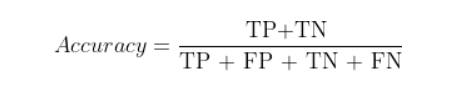

In [53]:
using Statistics #to have mean function

In [54]:
accuracy(x, y) = mean(onecold(mnist_model(x)) .== onecold(y))

accuracy (generic function with 1 method)

We need @epochs and throttle to run several epochs as mentioned before, and to use a callback function to monitor the training step.
eva

In [55]:
using Flux: @epochs,throttle

The **evalcb** is just the function passed to the callback cb which prints the loss and accuracy reached. **Throttle** specify that we want to call the evalcb function every **2 second**.
@epochs n  runs n epochs

In [56]:
evalcb = () -> println("\n\nloss : " , loss(X, Y), "  accuracy : ", accuracy(X,Y), "\nweights : ", ps[1][1:5]) # callback to show loss and acc

@epochs 2 Flux.train!(loss, ps, data, opt, cb = throttle(evalcb,1))

┌ Info: Epoch 1
└ @ Main C:\Users\mpoli\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121


LoadError: [91mReadOnlyMemoryError()[39m

#### same preprocessing step for the test set

In [13]:
# Same preprocessing for test set
test_X = hcat(float.(reshape.(images_test, :))...)
test_Y = onehotbatch(labels_test, 0:9);

Lets now classify the label of a random image in the test set.
Not that the **7-th element in the array is almost 1**, the others instead are nearly to 0.
**This means that our classification is 6**, because Julia start indexing from 1

In [14]:
mnist_model(test_X[:,5287]) # Note the 7th index ( corresponding to the digit 6 ) is nearly 1

10-element Array{Float32,1}:
 0.09027206
 0.08401938
 0.23668522
 0.06423377
 0.06423377
 0.06423377
 0.16455656
 0.06423377
 0.071493395
 0.09603826

Finally obtain the label from the array with the onecold function and print the actual label and the prediction label

In [15]:
#metto -1 perche l indexing in julia parte da 1
println("actual label : " , onecold(test_Y[:,5287])-1)
println("prediction : ", onecold(mnist_model(test_X[:,5287]))-1)
images_test[5287]

actual label : 6
prediction : 2


In [16]:

accuracy_train  = accuracy(X,Y) 
accuracy_test = accuracy(test_X,test_Y)

print("train accuracy : $accuracy_train   test accuracy : $accuracy_test")

train accuracy : 0.11946666666666667   test accuracy : 0.1124